In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=1
import matplotlib.pyplot as plt
from persim import plot_diagrams
from utils.utils import compute_ph, get_path
from utils.pd_utils import get_persistent_feature_id
from utils.fig_utils import plot_edges_on_scatter
from utils.dist_utils import get_dist
from utils.toydata_utils import get_toy_data
from vis_utils.plot import plot_scatter
import os
from matplotlib.patches import Circle, Polygon
import numpy as np

env: CUDA_VISIBLE_DEVICES=1


In [2]:
style_file = "utils.style"
plt.style.use(style_file)

In [3]:
root_path = get_path("data")
fig_path = os.path.join(root_path, "figures")

# PH fig

In [4]:
# get data
sigma = 0.2 #0.25
seed = 1 #3
n = 9 #25
d = 2
data = get_toy_data(dataset="toy_circle", n=n, d=d, seed=seed, gaussian={"sigma":sigma})

data[-2] = [1.3, 0.1]
data[0] = [1.5, -0.5]
data = np.concatenate([data, np.array([[0.9, 0.1]])], axis=0)

In [7]:
# compute / load PH result
#file_name =f"toy_circle_{n}_d_{d}_ortho_gauss_sigma_{sigma}_seed_{seed}_euclidean"
file_name = "ph_illustration"
dataset = "toy_circle"
res = compute_ph(dist=get_dist(data, distance="euclidean"),
                 file_name=file_name,
                 root_dir=root_path,
                 dataset=
                 dataset, 
                 dim=1,
                 delete_dists=True,
                 verbose=True,
                 force_recompute=True)


Writing dists for ph_illustration
Running Ripser for ph_illustration
Deleting dists for ph_illustration




In [8]:
# get index of most persistent feature
ind1 = get_persistent_feature_id(res, m=1, dim=1)
ind2 = get_persistent_feature_id(res, m=2, dim=1)

In [9]:
# birth / death times of most and second most peristent feature
birth1, death1 = res["dgms"][1][ind1]
birth2, death2 = res["dgms"][1][ind2]

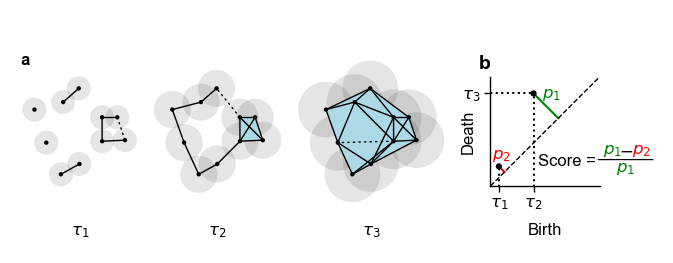

In [15]:
# plot figure
plt.rcParams['text.usetex'] = False

fig, ax = plt.subplots(ncols=4, figsize=(3.25, 1.2), width_ratios=[1, 1, 1, 1.1])

radii = [birth2, birth1, death1]
times = [r"$\tau_1$", r"$\tau_2$", r"$\tau_3$"]

for i, radius in enumerate(radii):
    # plot points
    plot_scatter(x=data, ax=ax[i], s=10, y="k", scalebar=False, alpha=1, zorder=6)
    
    # plot discs around points
    for pt in data:
        disc = Circle(pt, radius=radius / 2, facecolor='k', alpha=0.1, clip_on=False, edgecolor="none")  # (x, y), radius, color, and alpha
        ax[i].add_patch(disc)
        
    # print all existing edges
    dist = get_dist(data, distance="euclidean")
    mask = dist < radius
    mask_new = np.isclose(dist, radius)
    
    mask[mask_new] = False
    mask = np.triu(mask, k=1)
    mask_new = np.triu(mask_new, k=1)
    
    xx, yy = np.meshgrid(np.arange(len(data)), np.arange(len(data)))
    coords = np.stack([xx, yy], axis=-1)
    edges = coords[mask]
    
    plot_edges_on_scatter(ax=ax[i], edge_idx=edges, x=data, color="k",linewidth=0.5)
    plot_edges_on_scatter(ax=ax[i], edge_idx=coords[mask_new], x=data, color="k",linewidth=0.5, linestyle=(0, (1,3)))
    
   
    # plot triangles 
    for edge in edges:
        for pt_id in range(len(data)):
            if pt_id == edge[0] or pt_id == edge[1]:
                continue
            pt = data[pt_id]
            triangle = np.array([pt, data[edge[0]], data[edge[1]]])
            if np.all((get_dist(triangle, distance="euclidean") < radius * 1.0001)) :
                # Create a polygon representing the triangle
                triangle = Polygon(triangle, closed=True, edgecolor='none', facecolor='lightblue', alpha=1.0)
                
                # Add the triangle to the axis
                ax[i].add_patch(triangle)
        
    # filtration times
    ax[i].text(0.5, 0.05, times[i],
        horizontalalignment='center',
        verticalalignment='center',
        transform=ax[i].transAxes)
                
# plot persistence diagram
plot_diagrams(res["dgms"], ax=ax[-1], plot_only=[1], color="k", colormap=style_file)
ax[-1].set_yticks([death1])
ax[-1].set_yticklabels([r"$\tau_3$"])
ax[-1].set_ylabel("Death", labelpad=-5)
ax[-1].set_xticks([birth2, birth1])
ax[-1].set_xticklabels([r"$\tau_1$", r"$\tau_2$"])
ax[-1].legend().set_visible(False)

# plot dotted lines in persistence diagram
ax[-1].plot([0, birth1], [death1, death1], zorder=-1, c="k", linestyle="dotted")
ax[-1].plot([birth1, birth1], [0, death1], zorder=-1, c="k", linestyle="dotted")
ax[-1].plot([birth2, birth2], [0, death2], zorder=-1, c="k", linestyle="dotted")


mid = (birth1 + death1) / 2
ax[-1].plot([birth1, mid], [death1, mid], zorder=-1, c="g")

mid2 = (birth2 + death2) / 2
ax[-1].plot([birth2, mid2], [death2, mid2], zorder=-1, c="r")


# plot detection score formula
ax[-1].text(1.15, 1.45, "$p_1$",
            color="g",
        horizontalalignment='center',
        verticalalignment='center')
ax[-1].text(0.66, 0.85, "$p_2$",
            color="r",
        horizontalalignment='center',
        verticalalignment='center')

left = 0.55
bottom = 0.8
ax[-1].text(left +0.75, bottom, 'Score =',
        horizontalalignment='center',
        verticalalignment='center')

left = left + 0.35
ax[-1].text(left +0.85, bottom + 0.1, '$p_1$',
            color="g",
        horizontalalignment='center',
        verticalalignment='center')
ax[-1].text(left +0.99, bottom + 0.1, '$-$',
        horizontalalignment='center',
        verticalalignment='center')

ax[-1].text(left +1.14, bottom + 0.1, '$p_2$',
            color="r",
        horizontalalignment='center',
        verticalalignment='center')

ax[-1].text(left +0.98,  bottom + 0.08, '______',
            color="k",
        horizontalalignment='center',
        verticalalignment='center')

ax[-1].text(left +0.98, bottom - 0.08, '$p_1$',
            color="g",
        horizontalalignment='center',
        verticalalignment='center')

ax[0].text(
        s="a",
        x=-0.1,
        y=0.8,
        transform=ax[0].transAxes,
        fontweight="bold",
    )

ax[-1].set_title("b", fontweight="bold", loc="left", ha="right")

fig.savefig(os.path.join(fig_path, "fig_ph.pdf"))

In [9]:
# test wide gap score

In [17]:
from utils.pd_utils import wide_gap_score, get_features_above_gap

In [13]:
res["dgms"][1]

array([[0.632456, 0.743866],
       [0.975036, 1.4638  ]])

In [31]:
get_features_above_gap(res["dgms"][1], n_gap=2)

n_gap is larger than the number of features in the diagram. Returning the full diagram


array([[0.632456, 0.743866],
       [0.975036, 1.4638  ]])

In [43]:
wide_gap_score(res["dgms"][1], n_gap=0, n_features=5, mode="classification")

0